In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import glob
import csv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json

# Preprocessing functions
def merge_csi_label(csifile, labelfile, win_len=10, thrshd=0.6, step=1):
    activity = []
    with open(labelfile, 'r') as labelf:
        reader = csv.reader(labelf)
        for line in reader:
            label = line[0]
            activity.append(0 if label == 'NoActivity' else 1)
    activity = np.array(activity)
    csi = []
    with open(csifile, 'r') as csif:
        reader = csv.reader(csif)
        for line in reader:
            line_array = np.array([float(v) for v in line[1:52]])
            csi.append(line_array[np.newaxis, ...])
    csi = np.concatenate(csi, axis=0)
    assert csi.shape[0] == activity.shape[0]

    index = 0
    feature = []
    while index + win_len <= csi.shape[0]:
        cur_activity = activity[index:index+win_len]
        if np.sum(cur_activity) < thrshd * win_len:
            index += step
            continue
        cur_feature = csi[index:index+win_len, :][np.newaxis, ...]
        feature.append(cur_feature)
        index += step
    return np.concatenate(feature, axis=0)

def extract_csi_by_label(raw_folder, label, labels, win_len=10, thrshd=0.6, step=1):
    data_path_pattern = os.path.join(raw_folder, label + '*_data.csv')
    input_csv_files = sorted(glob.glob(data_path_pattern))
    annot_csv_files = [os.path.join(raw_folder, os.path.basename(f).replace('_data', '_label')) for f in input_csv_files]
    
    feature = []
    for csi_file, label_file in zip(input_csv_files, annot_csv_files):
        if os.path.exists(label_file):
            feature.append(merge_csi_label(csi_file, label_file, win_len, thrshd, step))
    feat_arr = np.concatenate(feature, axis=0)
    feat_label = np.zeros((feat_arr.shape[0], len(labels)))
    feat_label[:, labels.index(label)] = 1
    return feat_arr, feat_label

def train_valid_split(data, train_portion=0.85, seed=379):
    np.random.seed(seed)
    x_train, y_train, x_valid, y_valid = [], [], [], []
    for i, (x, y) in enumerate(data):
        indices = np.random.permutation(len(x))
        split = int(train_portion * len(x))
        x_train.append(x[indices[:split]])
        y_train.append(y[indices[:split]])
        x_valid.append(x[indices[split:]])
        y_valid.append(y[indices[split:]])
    return (
        np.concatenate(x_train), np.concatenate(y_train),
        np.concatenate(x_valid), np.concatenate(y_valid)
    )


In [2]:
# Attention Layer in PyTorch
class AttentionLayer(nn.Module):
    def __init__(self, num_state, input_dim):
        super(AttentionLayer, self).__init__()
        self.kernel = nn.Linear(input_dim, num_state)
        self.bias = nn.Parameter(torch.zeros(num_state))
        self.prob_kernel = nn.Linear(num_state, 1, bias=False)
    
    def forward(self, x):
        attention_state = torch.tanh(self.kernel(x) + self.bias)
        logits = self.prob_kernel(attention_state).squeeze(-1)
        probs = torch.softmax(logits, dim=1)
        weighted_feature = (x * probs.unsqueeze(-1)).sum(dim=1)
        return weighted_feature

In [ ]:
# CSI Model
class CSIModel(nn.Module):
    def __init__(self, input_dim=51, lstm_units=128, atten_units=300, output_dim=4):
        super(CSIModel, self).__init__()
        self.bilstm_1 = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
        self.bilstm_2 = nn.LSTM(lstm_units, lstm_units, batch_first=True, bidirectional=True)
        self.attention = AttentionLayer(atten_units, lstm_units * 2)
        self.fc = nn.Linear(lstm_units * 2, output_dim)
    
    def forward(self, x):
        lstm_out_1, _ = self.bilstm_1(x)
        att_out = self.attention(lstm_out_1)
        lstm_out_2 = self.bilstm_2(att_out)
        return self.fc(lstm_out_2)

In [ ]:
# Load and preprocess data
raw_data_folder = './processed/'
labels = ["fall", "run", "stand", "walk"]
data = [extract_csi_by_label(raw_data_folder, label, labels) for label in labels]

x_train, y_train, x_valid, y_valid = train_valid_split(data)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
valid_dataset = TensorDataset(torch.tensor(x_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [ ]:
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU in use: {device}")

model = CSIModel(output_dim=len(labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

history = {"epoch": [], "train_accuracy": [], "train_loss": []}


# Training loop
for epoch in range(100):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        loss = criterion(y_pred, torch.argmax(y_batch, axis=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        correct += (torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
        total += y_batch.size(0)

    history["epoch"].append(epoch + 1)
    history["train_loss"].append(total_loss / len(train_loader))
    history["train_accuracy"].append(correct / total)

    print(f"Epoch {epoch+1}, Accuracy: {correct / total:.4f}, Loss: {total_loss / len(train_loader):.4f}")

torch.save(model.state_dict(), "./pytorch_training/model/model_1.pth")
print("Model saved successfully.")
history_save_path = "./pytorch_training/model/training_history_1.json"
with open(history_save_path, "w") as f:
    json.dump(history, f)
print(f"Training history saved to {history_save_path}")


GPU in use: cuda
Epoch 1, Accuracy: 0.6208, Loss: 0.9216
Epoch 2, Accuracy: 0.7384, Loss: 0.7479
Epoch 3, Accuracy: 0.7912, Loss: 0.6365
Epoch 4, Accuracy: 0.8189, Loss: 0.5534
Epoch 5, Accuracy: 0.8374, Loss: 0.4877
Epoch 6, Accuracy: 0.8522, Loss: 0.4380
Epoch 7, Accuracy: 0.8630, Loss: 0.3985
Epoch 8, Accuracy: 0.8742, Loss: 0.3678
Epoch 9, Accuracy: 0.8810, Loss: 0.3424
Epoch 10, Accuracy: 0.8865, Loss: 0.3226
Epoch 11, Accuracy: 0.8922, Loss: 0.3088
Epoch 12, Accuracy: 0.8965, Loss: 0.2941
Epoch 13, Accuracy: 0.8983, Loss: 0.2829
Epoch 14, Accuracy: 0.9000, Loss: 0.2726
Epoch 15, Accuracy: 0.9004, Loss: 0.2653
Epoch 16, Accuracy: 0.9014, Loss: 0.2615
Epoch 17, Accuracy: 0.9045, Loss: 0.2538
Epoch 18, Accuracy: 0.9076, Loss: 0.2467
Epoch 19, Accuracy: 0.9080, Loss: 0.2420
Epoch 20, Accuracy: 0.9084, Loss: 0.2362
Epoch 21, Accuracy: 0.9108, Loss: 0.2318
Epoch 22, Accuracy: 0.9114, Loss: 0.2283
Epoch 23, Accuracy: 0.9151, Loss: 0.2233
Epoch 24, Accuracy: 0.9149, Loss: 0.2194
Epoch 25

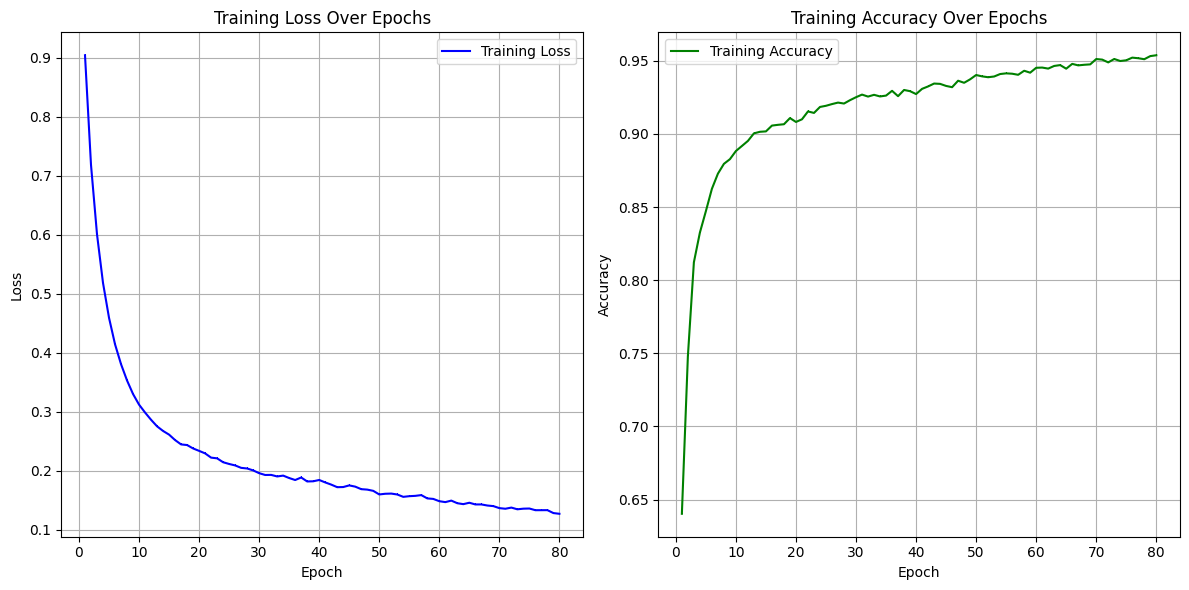

In [ ]:
# Load training history
history_save_path = "./pytorch_training/model/training_history_1.json"
with open(history_save_path, "r") as f:
    history = json.load(f)

# Extract data
epochs = history["epoch"]
train_loss = history["train_loss"]
train_accuracy = history["train_accuracy"]

plot_save_path = "./pytorch_training/plot/plot_1.png"

# Plotting
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", color="blue", marker=",")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label="Training Accuracy", color="green", marker=",")
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.savefig(plot_save_path, bbox_inches='tight')
plt.tight_layout()
plt.show()


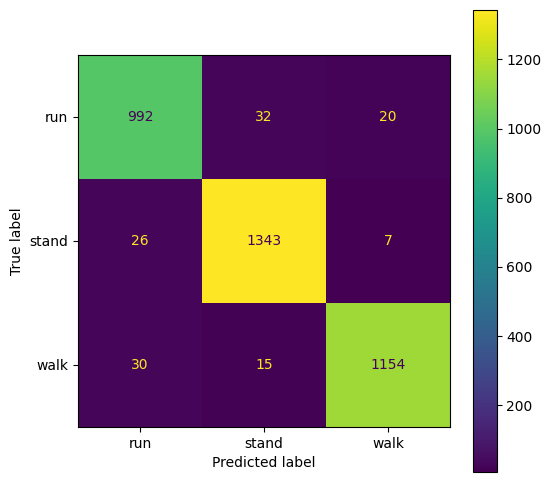

Test Accuracy: 96.25%


In [7]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x_batch, y_batch in valid_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch).cpu()

        y_true.extend(torch.argmax(y_batch, axis=1).numpy())
        y_pred.extend(torch.argmax(preds, axis=1).numpy())

        correct += (torch.argmax(preds, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
        total += y_batch.size(0)

# Confusion matrix
cm_save_path = "./pytorch_training/cm/confusion_matrix_18.png"
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6)) 
disp.plot(ax=ax)
plt.savefig(cm_save_path, bbox_inches='tight')
plt.show()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

In [8]:
# import torch
# from torch.utils.tensorboard import SummaryWriter
# import torch.optim as optim
# import torch.nn as nn
# import json

# # Model initialization
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"GPU in use: {device}")

# # Assuming CSIModel and train_loader are already defined elsewhere
# model = CSIModel(output_dim=len(labels)).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# history = {"epoch": [], "train_accuracy": [], "train_loss": []}

# # Initialize TensorBoard writer
# log_dir = './runs/training_logs'
# writer = SummaryWriter(log_dir)

# # Training loop
# for epoch in range(80):
#     model.train()
#     total_loss, correct, total = 0, 0, 0

#     for i, (x_batch, y_batch) in enumerate(train_loader):
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         y_pred = model(x_batch)

#         loss = criterion(y_pred, torch.argmax(y_batch, axis=1))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         correct += (torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
#         total += y_batch.size(0)

#         # Log metrics at each batch (optional, can adjust frequency)
#         if i % 10 == 0:  # Log every 10th batch (you can change this frequency)
#             writer.add_scalar("Loss/Train/Batch", loss.item(), epoch * len(train_loader) + i)
#             writer.add_scalar("Accuracy/Train/Batch", correct / total, epoch * len(train_loader) + i)

#     # Calculate epoch metrics
#     epoch_loss = total_loss / len(train_loader)
#     epoch_accuracy = correct / total
#     history["epoch"].append(epoch + 1)
#     history["train_loss"].append(epoch_loss)
#     history["train_accuracy"].append(epoch_accuracy)

#     # Log metrics at the end of each epoch
#     writer.add_scalar("Loss/Train/Epoch", epoch_loss, epoch)
#     writer.add_scalar("Accuracy/Train/Epoch", epoch_accuracy, epoch)

#     print(f"Epoch {epoch+1}, Accuracy: {epoch_accuracy:.4f}, Loss: {epoch_loss:.4f}")

# # Save the training history
# history_save_path = "./pytorch_training/model/training_history_8.json"
# with open(history_save_path, "w") as f:
#     json.dump(history, f)
# print(f"Training history saved to {history_save_path}")

# # Close TensorBoard writer after training
# writer.close()
# print(f"Training complete. Logs saved to {log_dir}. Use `tensorboard --logdir={log_dir}` to visualize.")
